# EDA Series temporales

## Introducción
En este notebook vamos a implementar una pequeña __red de neuronas de tipo LSTM__ para predecir valores en una serie temporal. Para ello seguiremos, aunque de forma muy superficial, el proceso habitual de estudio y desarrollo de un modelo en ciencia de datos. Podemos resumir ese proveso en cuatro grandes pasos:
1. Investigación: fase de definición del problema, estudio de calidad del dato y exploración de datos.
2. Desarrollo: fase de desarrollo y entrenamiento de los modelos. En esta fase nos enmarcaríamos actualmente.
3. Despliegue: productivicación del modelo y operación del mismo.
4. Validación: validación de la hipotesis inicial y estudio de la precisión del modelo.

Este proceso es iterativo, por lo que al llegar al punto cuatro se vuelve al punto uno para mejorar el proceso y el modelo.

<img src="./assets/dataflow.png" width="800">

## Dataset
El dataset que vamos a utilizar es un conjunto de datos del [UCI Machine Learning Archive](https://archive.ics.uci.edu/ml/index.php). Este dataset contiene información sobre varias medidas de consumo electrico en un hogar frances entre diciembre de 2006 y noviembre de 2010 (47 meses) a nivel minuto. Es especialmente interesante porque __cumple con dos de las principales premisas en redes de neuronas__:

* Gran cantidad de datos (casi XXX de observaciones).
* Datos numericos.

Además, es un conjunto de datos bastante limpio, algo que nos evitará en gran medida el paso de limpieza de datos.

### Source
[Individual household electric power consumption Data Set](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)

## Importación de librerías y lectura de datos

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
power_comsumption = pd.read_csv('datasets/household_power_consumption.txt', delimiter=';', low_memory=False)


display(power_comsumption.dtypes)
display(power_comsumption)

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [3]:
power_comsumption['timestamp'] = pd.to_datetime(power_comsumption['Date'] + ' ' + power_comsumption['Time'])
power_comsumption['Global_active_power'] = pd.to_numeric(power_comsumption['Global_active_power'], errors='coerce')
power_comsumption['Voltage'] = pd.to_numeric(power_comsumption['Voltage'], errors='coerce')
power_comsumption['Global_intensity'] = pd.to_numeric(power_comsumption['Global_intensity'], errors='coerce')

power_comsumption = power_comsumption.loc[:,['timestamp','Global_active_power', 'Voltage', 'Global_intensity']]

display(power_comsumption.dtypes)
display(power_comsumption.head(5))

timestamp              datetime64[ns]
Global_active_power           float64
Voltage                       float64
Global_intensity              float64
dtype: object

,timestamp,Global_active_power,Voltage,Global_intensity
0,2006-12-16 17:24:00,4.216,234.84,18.4
1,2006-12-16 17:25:00,5.360,233.63,23.0
2,2006-12-16 17:26:00,5.374,233.29,23.0
3,2006-12-16 17:27:00,5.388,233.74,23.0
4,2006-12-16 17:28:00,3.666,235.68,15.8


Text(0.5, 0, 'Tiempo')

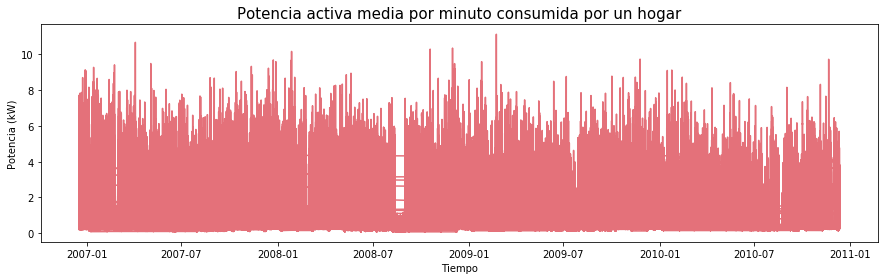

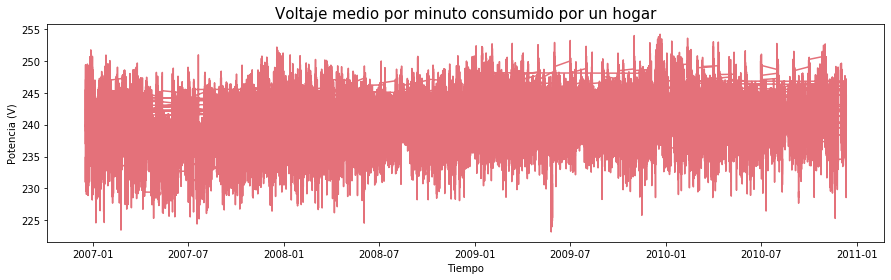

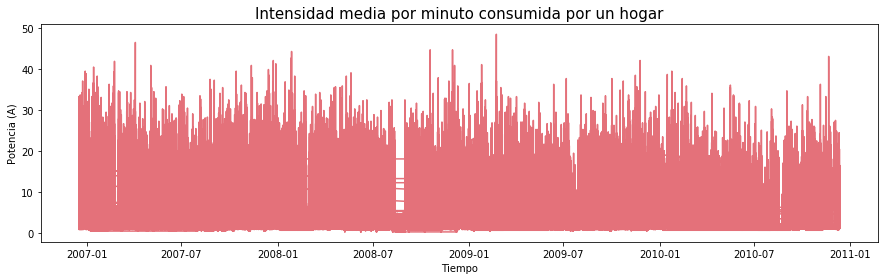

In [8]:
plt.figure(figsize=(15,4))
x = power_comsumption['timestamp']
y = power_comsumption['Global_active_power']

plt.plot(x,y, color = '#E4717A')

plt.title('Potencia activa media por minuto consumida por un hogar', size = 15)
plt.ylabel('Potencia (kW)', size = 10)
plt.xlabel('Tiempo', size = 10)


plt.figure(figsize=(15,4))
x = power_comsumption['timestamp']
y = power_comsumption['Voltage']

plt.plot(x,y, color = '#E4717A')

plt.title('Voltaje medio por minuto consumido por un hogar', size = 15)
plt.ylabel('Potencia (V)', size = 10)
plt.xlabel('Tiempo', size = 10)


plt.figure(figsize=(15,4))
x = power_comsumption['timestamp']
y = power_comsumption['Global_intensity']

plt.plot(x,y, color = '#E4717A')

plt.title('Intensidad media por minuto consumida por un hogar', size = 15)
plt.ylabel('Potencia (A)', size = 10)
plt.xlabel('Tiempo', size = 10)

In [47]:
power_comsumption_hourly = power_comsumption.groupby(power_comsumption['timestamp'].dt.floor('h')).mean()
power_comsumption_hourly = power_comsumption_hourly.reset_index()

power_comsumption_hourly

,timestamp,Global_active_power,Voltage,Global_intensity
0,2006-12-16 17:00:00,4.222889,234.643889,18.100000
1,2006-12-16 18:00:00,3.632200,234.580167,15.600000
2,2006-12-16 19:00:00,3.400233,233.232500,14.503333
3,2006-12-16 20:00:00,3.268567,234.071500,13.916667
4,2006-12-16 21:00:00,3.056467,237.158667,13.046667
...,...,...,...,...
34584,2010-12-11 19:00:00,2.391967,232.183833,10.336667
34585,2010-12-11 20:00:00,1.753333,234.007500,7.500000
34586,2010-12-11 21:00:00,1.114900,236.543667,4.746667
34587,2010-12-11 22:00:00,0.320533,240.140667,1.373333


Text(0.5, 0, 'Tiempo')

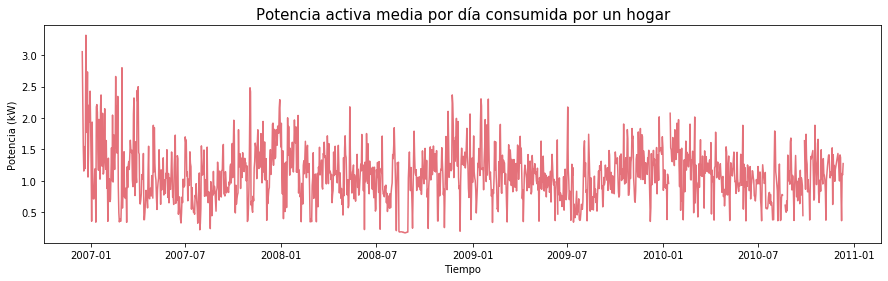

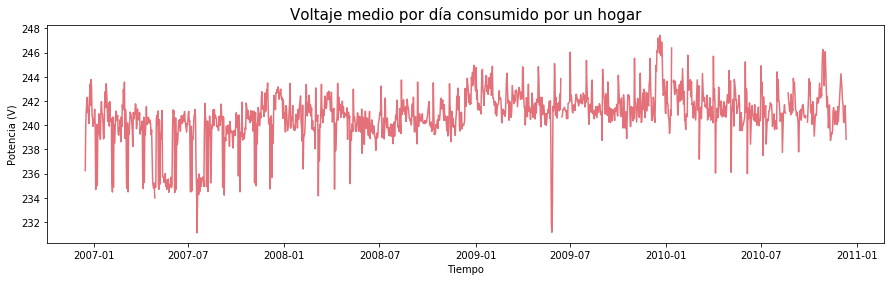

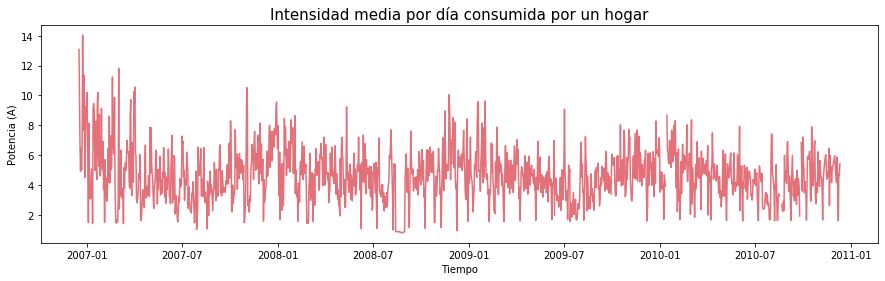

In [50]:
power_comsumption_hourly = power_comsumption.groupby(power_comsumption['timestamp'].dt.floor('d')).mean()
power_comsumption_hourly = power_comsumption_hourly.reset_index()

plt.figure(figsize=(15,4))
x = power_comsumption_hourly['timestamp']
y = power_comsumption_hourly['Global_active_power']

plt.plot(x,y, color = '#E4717A')

plt.title('Potencia activa media por día consumida por un hogar', size = 15)
plt.ylabel('Potencia (kW)', size = 10)
plt.xlabel('Tiempo', size = 10)


plt.figure(figsize=(15,4))
x = power_comsumption_hourly['timestamp']
y = power_comsumption_hourly['Voltage']

plt.plot(x,y, color = '#E4717A')

plt.title('Voltaje medio por día consumido por un hogar', size = 15)
plt.ylabel('Potencia (V)', size = 10)
plt.xlabel('Tiempo', size = 10)


plt.figure(figsize=(15,4))
x = power_comsumption_hourly['timestamp']
y = power_comsumption_hourly['Global_intensity']

plt.plot(x,y, color = '#E4717A')

plt.title('Intensidad media por día consumida por un hogar', size = 15)
plt.ylabel('Potencia (A)', size = 10)
plt.xlabel('Tiempo', size = 10)

## Preprocesado de datos
El preprocesado de los datos (no confundir con la limpieza de datos) es un paso previo al entrenamiento del modelo donde transformamos nuestros datos a la forma y tipo que necesita la red de neuronas. Aunque este proceso aplica en general para casi todos los modelos de ML y tiene pasos tan variados como los datos que podamos recibir, en este tipo de modelos generalmente se suelen realizar, por ejemplo, los siguientes preprocesados:

* Normalización: se normalizan los valores numericos a valores entre cero y uno.
* One hot encoding: se convierten variables categoricas (por ejemplo tipo de fruta) a variables numericas. Este metodo genera columnas extras (una por cada distinta categoría que exista) que tomarán valores de uno o cero.
* _Reshaping_: se reordenan las dimesiones de los datos, preparandolas para el formato que espera la red de neuronas.
* Devidir el dataset: se divide el dataset en los conjuntos de entranamiento y test (en ocasiones se genera también un conjunto de validacion).

Hablaremos ahora de los métodos que utilizaremos en este caso.

### Normalización
Las redes de neuronas, a parte de necesitar inputs numericos, funcionan mejor con valores de entrada normalizados e inicialización de pesos en valores cercanos a cero. Esto se debe a un efecto llamado __saturación__ que se puede producir en algunas neuronas, según su función de activación. Sobre todo en caso de utilizar funciones sigmoidales o tangenciales, en caso de tener valores de entrada a la función de activación muy grandes (positivos o negativos) la salida es casi constante. De esta forma, si las entradas o los pesos tomasen valores muy grandes, el aprendizaje se terminaría estancando en esas salidas casi constantes (independientemente de lo que variasemos los pesos).

<img src="https://imiloainf.files.wordpress.com/2013/11/activation_funcs1.png" width="400">

### Reshaping
En este caso el formato que espera la red LSTM es un formato tridimensional siguiendo el esquema `[samples, time steps, features]`.
* `samples`: esta dimensión representa a las observaciones con que vamos a alimentar la red LSTM.
* `time steps`: un instante de medida en una observación.
* `features`: esta dimentsión representa las features, o lo que es lo mismo, las caracteristicas de cada una de nuestras observaciones a partir de las que queremos que se genere la salida.

### Dividir el dataset
Se divide el dataset en el conjunto de entrenamiento y el conjunto de test. En este caso lo dividermos en 80%-20%, aunque los porcentajes son variables. Normalmente se intenta que los datasets esten balanceados y tengan una distribución de datos aleatorios (para que incluyan todos los patrones). En los casos de series temporales, sin embargo, es muy importante que ambos conjuntos sean trozos ordenados de la serie.

In [74]:
from sklearn.preprocessing import MinMaxScaler

clean_pc = power_comsumption.dropna(subset=['Global_active_power'])
clean_pc = clean_pc.sort_values('timestamp', ascending=True)
display(clean_pc.shape)

dataset = clean_pc.Global_active_power.values.astype('float32')
display(dataset)
dataset = np.reshape(dataset, (-1, 1))
display(dataset)
display(dataset.shape)

print()
print("Max: {:f}\nMin: {:f}\n".format(max(dataset)[0], min(dataset)[0]))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print("Max: {:f}\nMin: {:f}\n".format(max(dataset)[0], min(dataset)[0]))

train_len = int(len(dataset) * 0.80)
test_len = len(dataset) - train_len
train, test = dataset[0:train_len,:], dataset[train_len:len(dataset),:]

display(train)
display(train.shape)
display(test)
display(test.shape)

(2049280, 4)

array([4.216, 5.36 , 5.374, ..., 0.688, 0.688, 0.688], dtype=float32)

array([[4.216],
       [5.36 ],
       [5.374],
       ...,
       [0.688],
       [0.688],
       [0.688]], dtype=float32)

(2049280, 1)


Max: 11.122000
Min: 0.076000

Max: 1.000000
Min: 0.000000



array([[0.37479633],
       [0.47836325],
       [0.47963068],
       ...,
       [0.5017201 ],
       [0.3903676 ],
       [0.40068805]], dtype=float32)

(1639424, 1)

array([[0.35596597],
       [0.42748508],
       [0.3829441 ],
       ...,
       [0.05540468],
       [0.05540468],
       [0.05540468]], dtype=float32)

(409856, 1)

In [75]:
def generate_dataset(dataset, window=1):
    X, Y = [], []
    for i in range(len(dataset) - window - 1):
        a = dataset[i:(i + window), 0]
        X.append(a)
        Y.append(dataset[i + window, 0])
    return np.array(X), np.array(Y)


In [77]:
window = 30
X_train, Y_train = generate_dataset(train, window)
X_test, Y_test = generate_dataset(test, window)

display(Y_train)
display(Y_train.shape)
display(Y_test)
display(Y_test.shape)

# [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

display(X_train)
display(X_train.shape)
display(X_test)
display(X_test.shape)

array([0.23936269, 0.33333334, 0.38620317, ..., 0.56038386, 0.5017201 ,
       0.3903676 ], dtype=float32)

(1639393,)

array([0.11732754, 0.11968134, 0.11732754, ..., 0.05540468, 0.05540468,
       0.05540468], dtype=float32)

(409825,)

array([[[0.37479633, 0.47836325, 0.47963068, ..., 0.28535217,
         0.2880681 , 0.28082567]],

       [[0.47836325, 0.47963068, 0.4808981 , ..., 0.2880681 ,
         0.28082567, 0.23936269]],

       [[0.47963068, 0.4808981 , 0.32500455, ..., 0.28082567,
         0.23936269, 0.33333334]],

       ...,

       [[0.14919429, 0.15046172, 0.14792687, ..., 0.57867104,
         0.57450664, 0.5736013 ]],

       [[0.15046172, 0.14792687, 0.14865112, ..., 0.57450664,
         0.5736013 , 0.56038386]],

       [[0.14792687, 0.14865112, 0.14702156, ..., 0.5736013 ,
         0.56038386, 0.5017201 ]]], dtype=float32)

(1639393, 1, 30)

array([[[0.35596597, 0.42748508, 0.3829441 , ..., 0.2151005 ,
         0.12366468, 0.11968134]],

       [[0.42748508, 0.3829441 , 0.3117871 , ..., 0.12366468,
         0.11968134, 0.11732754]],

       [[0.3829441 , 0.3117871 , 0.4120949 , ..., 0.11968134,
         0.11732754, 0.11968134]],

       ...,

       [[0.07858048, 0.06717364, 0.06083651, ..., 0.05576679,
         0.05558573, 0.05558573]],

       [[0.06717364, 0.06083651, 0.05793953, ..., 0.05558573,
         0.05558573, 0.05540468]],

       [[0.06083651, 0.05793953, 0.06047438, ..., 0.05558573,
         0.05540468, 0.05540468]]], dtype=float32)

(409825, 1, 30)

## Generación del modelo
Vamos a generar un modelo LSTM con la siguiente arquitectura:
* Una capa LSTM (con 100 neuronas).
* Una capa de Dropout.
* Una capa densa fullyconnected (con 1 neurona).

Normalmente los parámetros que se modifican en las redes de neuronas, a parte del número y tipo de capas son:
* Número de neuronas en cada capa: afecta intuitivamente a la cantidad de patrones diferentes que identifica.
* Función de activación de cada capa: afecta al tipo de aproximación que se realiza y al comportamiento general de la red, como veiamos anteriormente.
* Dropout: no tiene por qué aparecer en todas las capas.

### Dropout
El dropuout es una técnica muy utilizada en Deep Learning que nos permite, durante el aprendizaje, "eliminar" (ignorar) de forma aleatoria algunas neuronas para evitar el sobreaprendizaje. Esta capa nos permite definir los parámetros del dropout (el porcentaje de neuronas que se ignorarán) y las neuronas que se van a ver afectadas por este proceso (la capa anterior).

### Capa densa
Es una capa tradicional de red de neuronas donde todas las salidas de la capa anterior se conectan con las neuronas (o neurona en este caso) de esta capa. En nuestro caso nos va a permitir traducir el estado interno de la capa LSTM a lo que queremos predecir, un único valor (el siguiente en la serie).

## Hiperparámetros
Todos los modelos de ML tienen una serie de parámetros que afectan al funcionamiento y aprendizaje  del mismo y son independientes de la arquitectura de la red (capas y neuronas). Los llamamos hiperparámetros.
* _Loss metric_: Métrica de error que se intentará optimizar durante el proceso de aprendizaje. En este caso el error cuadratico medio (MSE).
* _Optimizer_: Optimizador que se utilizará durante el proceso de aprendizaje. En este caso [Adam](https://arxiv.org/abs/1412.6980), muy utilizado en Deep Learning.

In [80]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

W0901 14:52:46.589534 4637599168 deprecation_wrapper.py:119] From /Users/axelblanco/miniconda3/envs/temporal-series-hands-on/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 14:52:46.636060 4637599168 deprecation_wrapper.py:119] From /Users/axelblanco/miniconda3/envs/temporal-series-hands-on/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 14:52:46.643077 4637599168 deprecation_wrapper.py:119] From /Users/axelblanco/miniconda3/envs/temporal-series-hands-on/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 14:52:47.001837 4637599168 deprecation_wrapper.py:119] From /Users/axelblanco/miniconda3/envs/temporal-series-hands-on/lib/python3.7/site-packages/ke

Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 241s 147us/step - loss: 7.7873e-04 - val_loss: 4.2651e-04
Epoch 2/20
1639393/1639393 [==============================] - 241s 147us/step - loss: 6.6240e-04 - val_loss: 4.3437e-04
Epoch 3/20
1639393/1639393 [==============================] - 225s 137us/step - loss: 6.5307e-04 - val_loss: 4.5972e-04
Epoch 4/20
1639393/1639393 [==============================] - 232s 141us/step - loss: 6.4780e-04 - val_loss: 4.4911e-04
Epoch 5/20
1639393/1639393 [==============================] - 3140s 2ms/step - loss: 6.4258e-04 - val_loss: 4.4484e-04
Epoch 6/20
1639393/1639393 [==============================] - 4686s 3ms/step - loss: 6.4014e-04 - val_loss: 4.4215e-04
Epoch 7/20
1639393/1639393 [==============================] - 210s 128us/step - loss: 6.3662e-04 - val_loss: 4.2670e-04
Epoch 8/20
1639393/1639393 [==============================] - 229s 140us/step - loss: 6.3524e-04 - val_loss: 

In [90]:
import json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

with open('history.json', 'w') as f:
    json.dump(history.history, f)

Saved model to disk


In [93]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5")
print("Loaded model from disk")

json_file = open('history.json', 'r')
loaded_history = json.loads(json_file.read())
json_file.close()


Loaded model from disk


In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_t = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train RMSE:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test RMSE:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Root Mean Squared Error: 0.26649222630086566
Test Root Mean Squared Error: 0.22189757479807357


## Evaluar el modelo
A la hora de evaluar el aprendizaje de un modelo de ML habitualmente se presta atención a la evolución del _loss_ o del _accuracy_ a lo largo de las iteraciones, tanto en el conjunto de entrenamiento como de test. Esto nos da información sobre la forma en la que está aprendiendo el modelo. Sin embargo, en muchas ocasiones no ofrece información "real" sobre lo bueno o malo que es nuestro modelo.

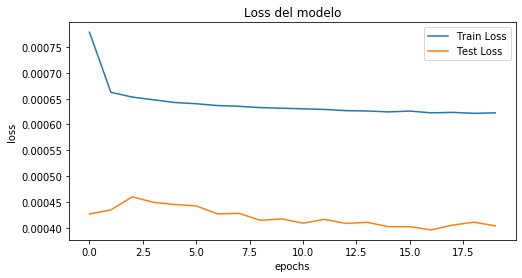

In [87]:
plt.figure(figsize=(8,4))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.title('Loss del modelo')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.show()

Para eso, en este caso vamos a visualizar los primeros 200 minutos del conjunto de entrenamiento, tanto los reales como los que hemos precedido. Esto nos dará una idea de como de "bien" o "mal" funciona nuestra red a grandes rasgos. En otros contextos este tipo de pruebas podrían ser tests A/B en entornos reales o pruebas con usuarios.

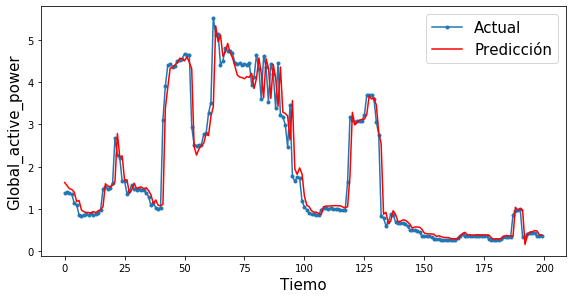

In [96]:
aa = [x for x in range(200)]

plt.figure(figsize=(8,4))

plt.plot(aa, Y_test[0][:200], marker='.', label="Actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="Predicción")

plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Tiempo', size=15)
plt.legend(fontsize=15)

plt.show()